In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from multiprocessing import Pool

import torch 
torch.manual_seed(0) 
import gpytorch 

Data Prep

In [2]:
# reading the dataset

data = pd.read_csv('online_shoppers_intention.csv')
data.dropna(inplace=True)
print(data.shape)
data.head(8)

(12316, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0.0,0.0,0.0,0.0,19.0,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False


In [3]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497,2.124147,2.357584,3.148019,4.070477
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020,0.911566,1.718028,2.402211,4.024598
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [4]:
print(data.isnull().sum().sum())
data = pd.get_dummies(data)
le = LabelEncoder()
data['Revenue'] = le.fit_transform(data['Revenue'])
data['Revenue'].value_counts()

0


0    10408
1     1908
Name: Revenue, dtype: int64

In [5]:
data.dtypes

Administrative                   float64
Administrative_Duration          float64
Informational                    float64
Informational_Duration           float64
ProductRelated                   float64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
SpecialDay                       float64
OperatingSystems                   int64
Browser                            int64
Region                             int64
TrafficType                        int64
Weekend                             bool
Revenue                            int64
Month_Aug                          uint8
Month_Dec                          uint8
Month_Feb                          uint8
Month_Jul                          uint8
Month_June                         uint8
Month_Mar                          uint8
Month_May                          uint8
Month_Nov                          uint8
Month_Oct       

In [13]:
from imblearn.over_sampling import SMOTE, ADASYN


Using TensorFlow backend.
/home/harsh/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/harsh/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/harsh/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/harsh/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [ ]:
# x,y = x_resampled,y_resampled
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
# print("Shape of x_train :", x_train.shape)
# print("Shape of y_train :", y_train.shape)
# print("Shape of x_test :", x_test.shape)
# print("Shape of y_test :", y_test.shape)

In [9]:
x=data
x = x.drop(['Revenue'], axis = 1)
y = data['Revenue']
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
y_train[y_train==0] = -1
y_train[y_train==1] = 1
y_test[y_test==0] = -1
y_test[y_test==1] = 1
print(np.sum(y_train==-1))
# x_train, y_train = SMOTE().fit_resample(x_train, y_train)
# x_train, y_train = ADASYN().fit_resample(x_train,y_train)
print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

7276
Shape of x_train : (8621, 28)
Shape of y_train : (8621,)
Shape of x_test : (3695, 28)
Shape of y_test : (3695,)


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf_classi = RandomForestClassifier()
model_rf = model_rf_classi.fit(x_train,y_train)
y_pred_enrf = model_rf.predict(x_test)
print("\n Done")
print("\n AUC of Random Forest: ",roc_auc_score(y_test,y_pred_enrf))
print("Report:\n",classification_report(y_test,y_pred_enrf))

In [ ]:
#Without Oversampling

n_est_all = np.arange(5,450,10)
scores_all = []
for n_est in n_est_all:
    print("n_est=",n_est,end='')
    model_rf_classi = RandomForestClassifier(n_estimators=n_est,random_state=69)
    model_rf = model_rf_classi.fit(x_train,y_train)
    y_pred_enrf = model_rf.predict(x_test)
    auc_sc = roc_auc_score(y_test,y_pred_enrf)
    print("auc=",auc_sc)
    scores_all.append(auc_sc)
plt.scatter(n_est_all,scores_all)

In [ ]:
#With SMOTE

n_est_all = np.arange(5,450,10)
scores_all = []
for n_est in n_est_all:
    print("n_est=",n_est,end='')
    model_rf_classi = RandomForestClassifier(n_estimators=n_est,random_state=69)
    model_rf = model_rf_classi.fit(x_train,y_train)
    y_pred_enrf = model_rf.predict(x_test)
    auc_sc = roc_auc_score(y_test,y_pred_enrf)
    print("auc=",auc_sc)
    scores_all.append(auc_sc)
plt.scatter(n_est_all,scores_all)

In [ ]:
#With ADASYN

n_est_all = np.arange(5,450,10)
scores_all = []
for n_est in n_est_all:
    print("n_est=",n_est,end='')
    model_rf_classi = RandomForestClassifier(n_estimators=n_est,random_state=69)
    model_rf = model_rf_classi.fit(x_train,y_train)
    y_pred_enrf = model_rf.predict(x_test)
    auc_sc = roc_auc_score(y_test,y_pred_enrf)
    print("auc=",auc_sc)
    scores_all.append(auc_sc)
plt.scatter(n_est_all,scores_all)

XGB Regressor

In [ ]:
sumpos = np.sum(y_train==1)
sumneg = np.sum(y_train==-1)
print(sumpos,sumneg)

In [ ]:
from xgboost import XGBRegressor

xgmodel = XGBRegressor(n_jobs=-1,scale_pos_weight=sumneg/sumpos,eval_metric='auc')
print(xgmodel)
xgmodel.fit(x_train,y_train)
y_predxg = xgmodel.predict(x_test)
print("auc=",roc_auc_score(y_test,y_predxg))

In [ ]:
xgb_scores = []
for n_est in np.arange(10,200,10):
    for md in np.arange(1,20,3):        
        xgmodel = XGBRegressor(max_depth=md,n_estimators=n_est,n_jobs=-1,random_state=69,)
#         print(xgmodel)
        xgmodel.fit(x_train,y_train)
        y_predxg = xgmodel.predict(x_test)
        auc = roc_auc_score(y_test,y_predxg)
        print("auc=",auc)
        xgb_scores.append(auc)
    

In [ ]:
print("xgb best auc=",np.max(xgb_scores))

GP Regression

In [21]:
np.min(y_train),np.max(y_train)

(-1.0, 1.0)

In [22]:
train_x = torch.tensor(x_train)
train_y = torch.tensor(y_train)
test_x = torch.tensor(x_test)

In [23]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=x_train.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [25]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.955  noise: 0.077
Iter 2/50 - Loss: 0.948  noise: 0.070
Iter 3/50 - Loss: 0.939  noise: 0.064
Iter 4/50 - Loss: 0.929  noise: 0.058
Iter 5/50 - Loss: 0.927  noise: 0.052
Iter 6/50 - Loss: 0.921  noise: 0.048
Iter 7/50 - Loss: 0.910  noise: 0.043
Iter 8/50 - Loss: 0.908  noise: 0.039
Iter 9/50 - Loss: 0.905  noise: 0.036
Iter 10/50 - Loss: 0.901  noise: 0.032
Iter 11/50 - Loss: 0.887  noise: 0.029
Iter 12/50 - Loss: 0.878  noise: 0.027
Iter 13/50 - Loss: 0.880  noise: 0.024
Iter 14/50 - Loss: 0.868  noise: 0.022
Iter 15/50 - Loss: 0.865  noise: 0.020
Iter 16/50 - Loss: 0.866  noise: 0.019
Iter 17/50 - Loss: 0.860  noise: 0.017
Iter 18/50 - Loss: 0.859  noise: 0.015
Iter 19/50 - Loss: 0.848  noise: 0.014
Iter 20/50 - Loss: 0.844  noise: 0.013
Iter 21/50 - Loss: 0.847  noise: 0.012
Iter 22/50 - Loss: 0.837  noise: 0.011
Iter 23/50 - Loss: 0.834  noise: 0.010
Iter 24/50 - Loss: 0.831  noise: 0.009
Iter 25/50 - Loss: 0.833  noise: 0.009
Iter 26/50 - Loss: 0.831  noise: 0

KeyboardInterrupt: 

In [44]:
model.eval()
likelihood.eval()
# y_preds = model(test_x).mean

with torch.no_grad(), gpytorch.settings.max_cg_iterations(2000), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    
#     observed_pred = model(test_x)


In [45]:
observed_pred.mean

tensor([ 15.0995, -21.1579,  -0.4769,  ..., -68.9148,   0.0912,  -0.4799])

In [46]:
y_preds = observed_pred.mean.detach().numpy().copy()
print(y_preds)
print(np.min(y_preds))
print(np.max(y_preds))
print(np.median(y_preds))

[ 15.099534   -21.15795     -0.47692287 ... -68.91479      0.09115395
  -0.4799435 ]
-427.1869
281.94275
-0.48010454


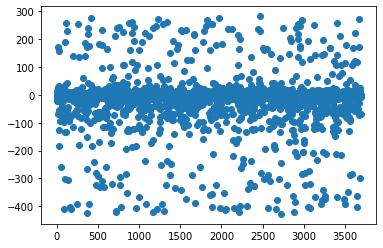

In [47]:
# plt.scatter(np.arange(len(y_test)),y_test)
plt.scatter(np.arange(len(y_preds)),y_preds)


In [48]:
y_preds[y_preds<-1] = -1
y_preds[y_preds>1] = 1

In [49]:
# y_preds = y_preds.detach().numpy()
# y_pred = y_preds.copy()
# y_pred[y_pred>=0] = 1
# y_pred[y_pred<0] = -1
# print("Report : \n", classification_report(y_test, y_preds))
print("AUC: ", roc_auc_score(y_test,y_preds))



AUC:  0.6131093349121768


Deep Gaussian Processes

In [6]:
import torch
import tqdm
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

In [7]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [18]:
train_x = torch.tensor(x_train)
train_y = torch.tensor(y_train)
test_x = torch.tensor(x_test)
test_y = torch.tensor(y_test)

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [13]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

        self.linear_layer = Linear(input_dims, 1)

    def forward(self, x):
        mean_x = self.mean_module(x) # self.linear_layer(x).squeeze(-1)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(self.num_samples, *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

In [14]:
num_output_dims = 1


class DeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_output_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = model.likelihood(model(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [15]:
model = DeepGP(train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()

In [16]:
# this is for running the notebook in our testing framework
num_epochs = 1 
num_samples = 3 


optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.tqdm_notebook(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())

/home/harsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/home/harsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [20]:
import gpytorch
import math


test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

model.eval()
predictive_means, predictive_variances, test_lls = model.predict(test_loader)
print(predictive_means)
rmse = torch.mean(torch.pow(predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

tensor([[-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891],
        [-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891],
        [-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891],
        ...,
        [-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891],
        [-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891],
        [-0.0891, -0.0891, -0.0891,  ..., -0.0891, -0.0891, -0.0891]])
RMSE: 0.935727596282959, NLL: 1.3964754343032837
